# Testing the ReGene framework

Set this to True if in Drive

In [1]:
inDrive = False

In [2]:
if inDrive:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('/content/drive/My Drive/Hybrid-CLUE/ReGene')

Mounted at /content/drive


## Setup


Import libraries

In [1]:
import importlib
import regene_models
importlib.reload(regene_models)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

Set the device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


Load the Datasets

In [3]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

Set the latent dimension

In [4]:
latent_dim = 256

Create a models directory if it doesn't exist

In [5]:
# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

## Classifier

### Training

First we define the classifier

In [11]:
classifier = regene_models.Classifier(latent_dim=latent_dim, num_classes=10, device=device)

Then we train

In [12]:
# Train classifier and save
classifier.train_classifier(trainloader, num_epochs=10, lr=0.001)
torch.save(classifier.state_dict(), 'models/classifier.pth')

Epoch [1/10], Loss: 0.0409
Epoch [2/10], Loss: 0.0086
Epoch [3/10], Loss: 0.0011
Epoch [4/10], Loss: 0.0199
Epoch [5/10], Loss: 0.0002
Epoch [6/10], Loss: 0.0003
Epoch [7/10], Loss: 0.0210
Epoch [8/10], Loss: 0.0010
Epoch [9/10], Loss: 0.0016
Epoch [10/10], Loss: 0.0006


### Testing


First let's test the classifier on a few images

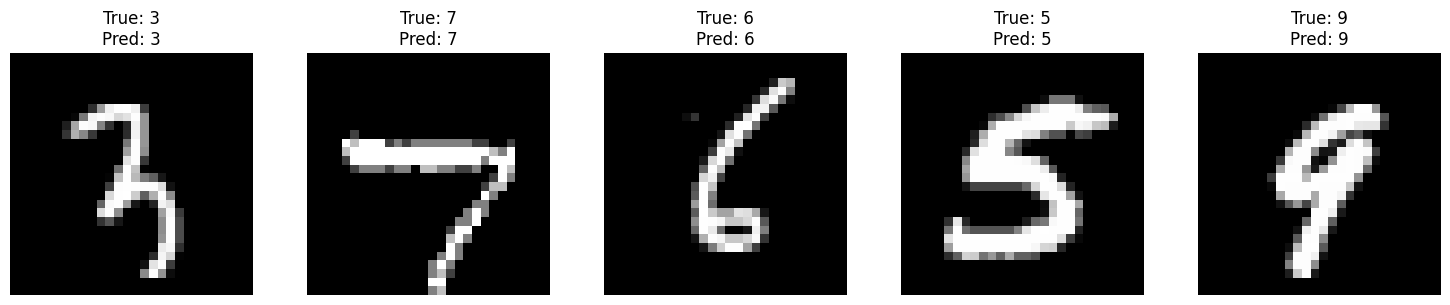

In [13]:
# Get random indices for test images
random_indices = torch.randint(0, len(trainset), (5,))
images = torch.stack([trainset[i][0] for i in random_indices])
labels = torch.tensor([trainset[i][1] for i in random_indices])

# Get predictions
classifier.eval()  # Set to evaluation mode
with torch.no_grad():
    images = images.to(device)
    _, predictions = classifier(images)
    predicted_classes = torch.argmax(predictions, dim=1)

# Plot images with true and predicted labels
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
    plt.title(f'True: {labels[i].item()}\nPred: {predicted_classes[i].cpu().item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()


We'll also visualise the latent space. This is done by taking the latent representations of 50 training images and plotting them in 2D using t-SNE.

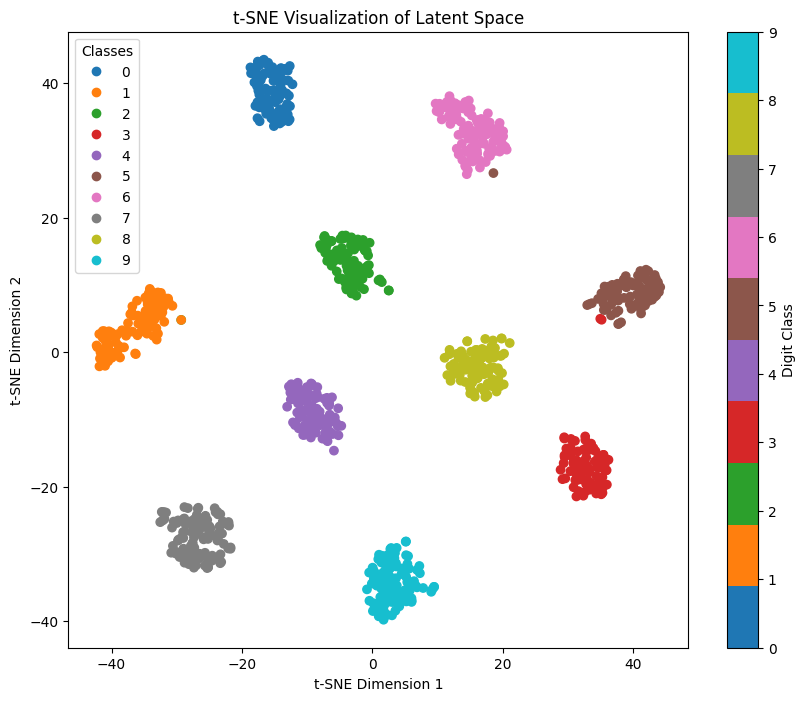

In [14]:
# Get latent representations for 50 random training images
random_indices = torch.randint(0, len(trainset), (1000,))
images = torch.stack([trainset[i][0] for i in random_indices])
labels = torch.tensor([trainset[i][1] for i in random_indices])

# Get latent representations
classifier.eval()
with torch.no_grad():
    images = images.to(device)
    latent_reps, _ = classifier(images)
    latent_reps = latent_reps.cpu().numpy()

# Perform t-SNE dimensionality reduction
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_reps)

# Plot the 2D latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10')
plt.colorbar(scatter, label='Digit Class')
plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


## Decoder

### Training

We define the decoder, and then train it using the classifier's latent space.

In [15]:
decoder = regene_models.Decoder(latent_dim=latent_dim, device=device)

In [16]:
decoder.train_decoder(trainloader, classifier, num_epochs=12, lr=0.001)
torch.save(decoder.state_dict(), 'models/decoder.pth')

Decoder Epoch [1/12], Loss: 0.0229
Decoder Epoch [2/12], Loss: 0.0223
Decoder Epoch [3/12], Loss: 0.0193
Decoder Epoch [4/12], Loss: 0.0183
Decoder Epoch [5/12], Loss: 0.0188
Decoder Epoch [6/12], Loss: 0.0159
Decoder Epoch [7/12], Loss: 0.0185
Decoder Epoch [8/12], Loss: 0.0129
Decoder Epoch [9/12], Loss: 0.0150
Decoder Epoch [10/12], Loss: 0.0148
Decoder Epoch [11/12], Loss: 0.0126
Decoder Epoch [12/12], Loss: 0.0156


### Testing


First less visualise some reconstructions

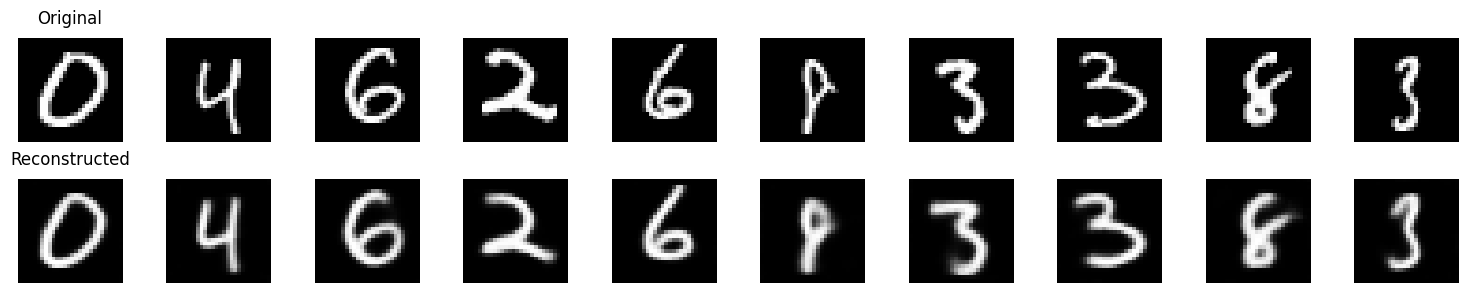

In [17]:
# Get 10 random images from training set
dataiter = iter(trainloader)
images, _ = next(dataiter)
images = images[:10].to(device)

# Get reconstructions
classifier.eval()
decoder.eval()
with torch.no_grad():
    z, _ = classifier(images)
    reconstructed = decoder(z)

# Plot original vs reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    # Original images
    axes[0,i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original', pad=10)

    # Reconstructed images
    axes[1,i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
    axes[1,i].axis('off')
    if i == 0:
        axes[1,i].set_title('Reconstructed', pad=10)

plt.tight_layout()
plt.show()


## Joint training


Let's try training the models with a joint objective

In [20]:
from importlib import reload
import regene_models
importlib.reload(regene_models)
from regene_models import Classifier

Alpha determines how much weight is given to the reconstruction loss.

In [21]:
joint_decoder = regene_models.Decoder(latent_dim=256, device=device)
joint_classifier = regene_models.Classifier(latent_dim=latent_dim, num_classes=10, device=device)
regene_models.train_joint(joint_classifier, joint_decoder, trainloader, num_epochs=12, lr=0.001, lambda_recon=0.8)

# Save models
torch.save(joint_decoder.state_dict(), 'models/joint_decoder.pth')
torch.save(joint_classifier.state_dict(), 'models/joint_classifier.pth')

Epoch [1/12], Total Loss: 0.0196, Classification Loss: 0.0236, Reconstruction Loss: 0.0186
Epoch [2/12], Total Loss: 0.0189, Classification Loss: 0.0495, Reconstruction Loss: 0.0112
Epoch [3/12], Total Loss: 0.0172, Classification Loss: 0.0453, Reconstruction Loss: 0.0102
Epoch [4/12], Total Loss: 0.0095, Classification Loss: 0.0086, Reconstruction Loss: 0.0097
Epoch [5/12], Total Loss: 0.0098, Classification Loss: 0.0014, Reconstruction Loss: 0.0119
Epoch [6/12], Total Loss: 0.0084, Classification Loss: 0.0035, Reconstruction Loss: 0.0097
Epoch [7/12], Total Loss: 0.0070, Classification Loss: 0.0003, Reconstruction Loss: 0.0086
Epoch [8/12], Total Loss: 0.0066, Classification Loss: 0.0000, Reconstruction Loss: 0.0082
Epoch [9/12], Total Loss: 0.0152, Classification Loss: 0.0384, Reconstruction Loss: 0.0094
Epoch [10/12], Total Loss: 0.0243, Classification Loss: 0.0864, Reconstruction Loss: 0.0088
Epoch [11/12], Total Loss: 0.0067, Classification Loss: 0.0000, Reconstruction Loss: 0.00

In [ ]:

# Get some test images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.to(device)

# Get reconstructions
with torch.no_grad():
    z, _ = joint_classifier(images)
    reconstructed = joint_decoder(z)

# Plot original vs reconstructed images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Original images
    axes[0,i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original', pad=10)

    # Reconstructed images
    axes[1,i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
    axes[1,i].axis('off')
    if i == 0:
        axes[1,i].set_title('Reconstructed', pad=10)

plt.tight_layout()
plt.show()


/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_24524/2056428412.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  joint_decoder_loaded.load_state_dict(torch.lo

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

## Training encoder and classifier separately


In this final section, we will train the encoder and classifier separately. The encoder is trained to minimise the reconstruction loss, and the classifier is trained to minimise the cross-entropy loss on the enocders latent space.

In [34]:
from regene_models import train_autoencoder, train_classifier_only

separate_classifier = regene_models.Classifier(latent_dim=latent_dim, num_classes=10, device=device)
separate_decoder = regene_models.Decoder(latent_dim=latent_dim, device=device)

In [35]:
# Train autoencoder
train_autoencoder(classifier=separate_classifier, decoder=separate_decoder, train_loader=trainloader, num_epochs=12, lr=0.001)

# Save model
torch.save(separate_decoder.state_dict(), 'models/separate_decoder.pth')

Epoch [1/12], Average Reconstruction Loss: 0.0529
Epoch [2/12], Average Reconstruction Loss: 0.0155
Epoch [3/12], Average Reconstruction Loss: 0.0136
Epoch [4/12], Average Reconstruction Loss: 0.0123
Epoch [5/12], Average Reconstruction Loss: 0.0059
Epoch [6/12], Average Reconstruction Loss: 0.0052
Epoch [7/12], Average Reconstruction Loss: 0.0049
Epoch [8/12], Average Reconstruction Loss: 0.0047
Epoch [9/12], Average Reconstruction Loss: 0.0045
Epoch [10/12], Average Reconstruction Loss: 0.0043
Epoch [11/12], Average Reconstruction Loss: 0.0041
Epoch [12/12], Average Reconstruction Loss: 0.0040


In [37]:
# Train autoencoder
train_classifier_only(separate_classifier, trainloader, num_epochs=10, lr=0.001)

# Save model
torch.save(separate_classifier.state_dict(), 'models/separate_classifier.pth')

## Comparison

We will now compare the performance of the different models.



In [42]:
# Load models
classifier_loaded = regene_models.Classifier(latent_dim=latent_dim, num_classes=10, device=device)
decoder_loaded = regene_models.Decoder(latent_dim=latent_dim, device=device)
classifier_loaded.load_state_dict(torch.load('models/classifier.pth', map_location=device))
decoder_loaded.load_state_dict(torch.load('models/decoder.pth', map_location=device))

joint_classifier_loaded = regene_models.Classifier(latent_dim=latent_dim, num_classes=10, device=device)
joint_decoder_loaded = regene_models.Decoder(latent_dim=latent_dim, device=device)
joint_classifier_loaded.load_state_dict(torch.load('models/joint_classifier.pth', map_location=device))
joint_decoder_loaded.load_state_dict(torch.load('models/joint_decoder.pth', map_location=device))

separate_classifier_loaded = regene_models.Classifier(latent_dim=latent_dim, num_classes=10, device=device)
separate_decoder_loaded = regene_models.Decoder(latent_dim=latent_dim, device=device)
separate_classifier_loaded.load_state_dict(torch.load('models/separate_classifier.pth', map_location=device))
separate_decoder_loaded.load_state_dict(torch.load('models/separate_decoder.pth', map_location=device))

models = [(classifier_loaded, decoder_loaded), (joint_classifier_loaded, joint_decoder_loaded), (separate_classifier_loaded, separate_decoder_loaded)]


/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_24524/3128444424.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier_loaded.load_state_dict(torch.load(

In [39]:
import torch.nn.functional as F
from torchmetrics import Accuracy
import pandas as pd
from IPython.display import display

# Function to calculate metrics
def calculate_metrics(classifier, decoder, test_loader):
    classifier.eval()
    decoder.eval()

    total = 0
    correct = 0
    mse_total = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get predictions and reconstructions
            z, outputs = classifier(images)
            reconstructed = decoder(z)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Calculate MSE
            mse = F.mse_loss(reconstructed, images)
            mse_total += mse.item()

    accuracy = 100 * correct / total
    avg_mse = mse_total / len(test_loader)

    return accuracy, avg_mse

# Calculate metrics for each model
model_names = ['Standard', 'Joint Training', 'Separate Training']
results = []

for (clf, dec), name in zip(models, model_names):
    accuracy, mse = calculate_metrics(clf, dec, trainloader)
    results.append({
        'Model': name,
        'Accuracy (%)': f'{accuracy:.2f}',
        'MSE': f'{mse:.4f}'
    })

# Create and display DataFrame
df = pd.DataFrame(results)
display(df)


,Model,Accuracy (%),MSE
0,Standard,99.54,0.0144
1,Joint Training,99.76,0.0079
2,Separate Training,95.39,0.0038


And compare their latent spaces

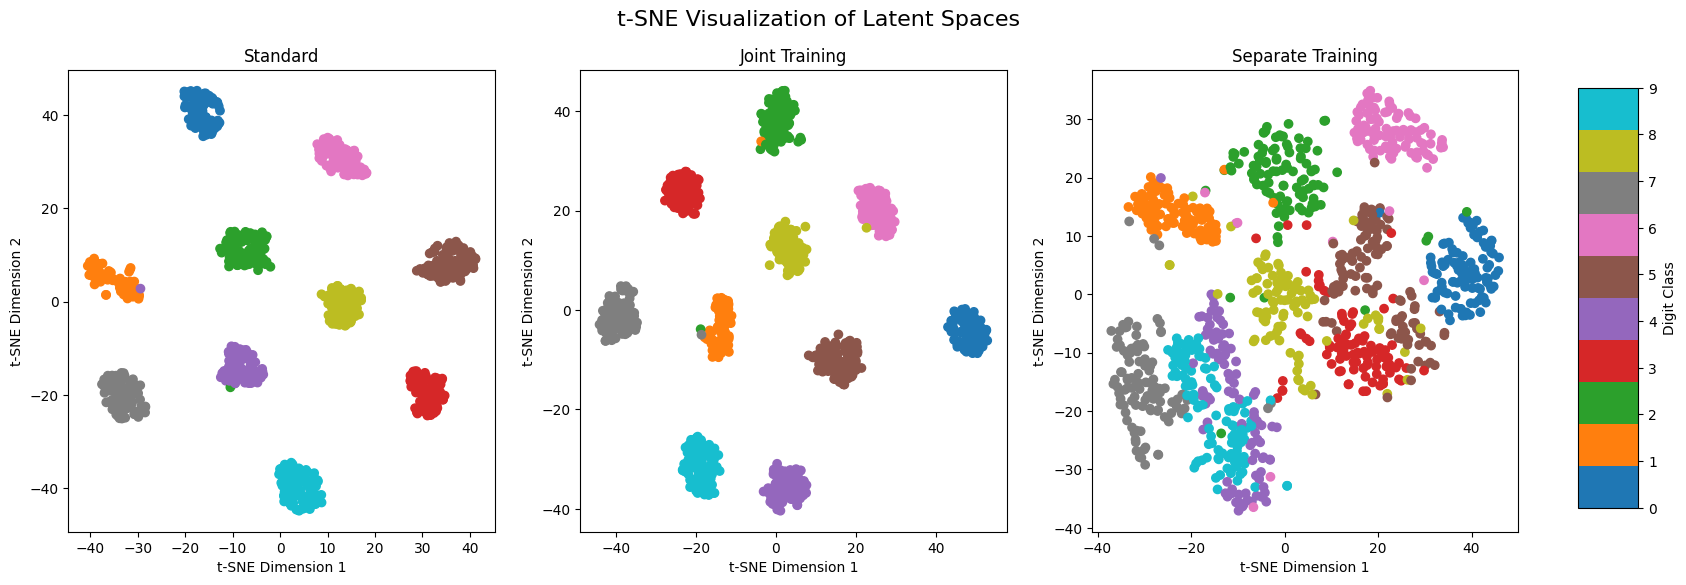

In [40]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assume latent_spaces, model_names, and labels are already defined

# Create the figure and a 1x3 grid for the main plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('t-SNE Visualization of Latent Spaces', fontsize=16)

# Run t-SNE for each model and plot
for i, (latent_reps, name) in enumerate(zip(latent_spaces, model_names)):
    tsne = TSNE(n_components=2, random_state=42)  # Create a new TSNE instance each time
    latent_2d = tsne.fit_transform(latent_reps)
    scatter = axes[i].scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10')
    axes[i].set_title(name)
    axes[i].set_xlabel('t-SNE Dimension 1')
    axes[i].set_ylabel('t-SNE Dimension 2')

# Adjust the layout to make room on the right for a colorbar
fig.subplots_adjust(right=0.85)

# Create a new axis for the colorbar on the right
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # [left, bottom, width, height] in figure coordinates
fig.colorbar(scatter, cax=cbar_ax, label='Digit Class')

plt.show()


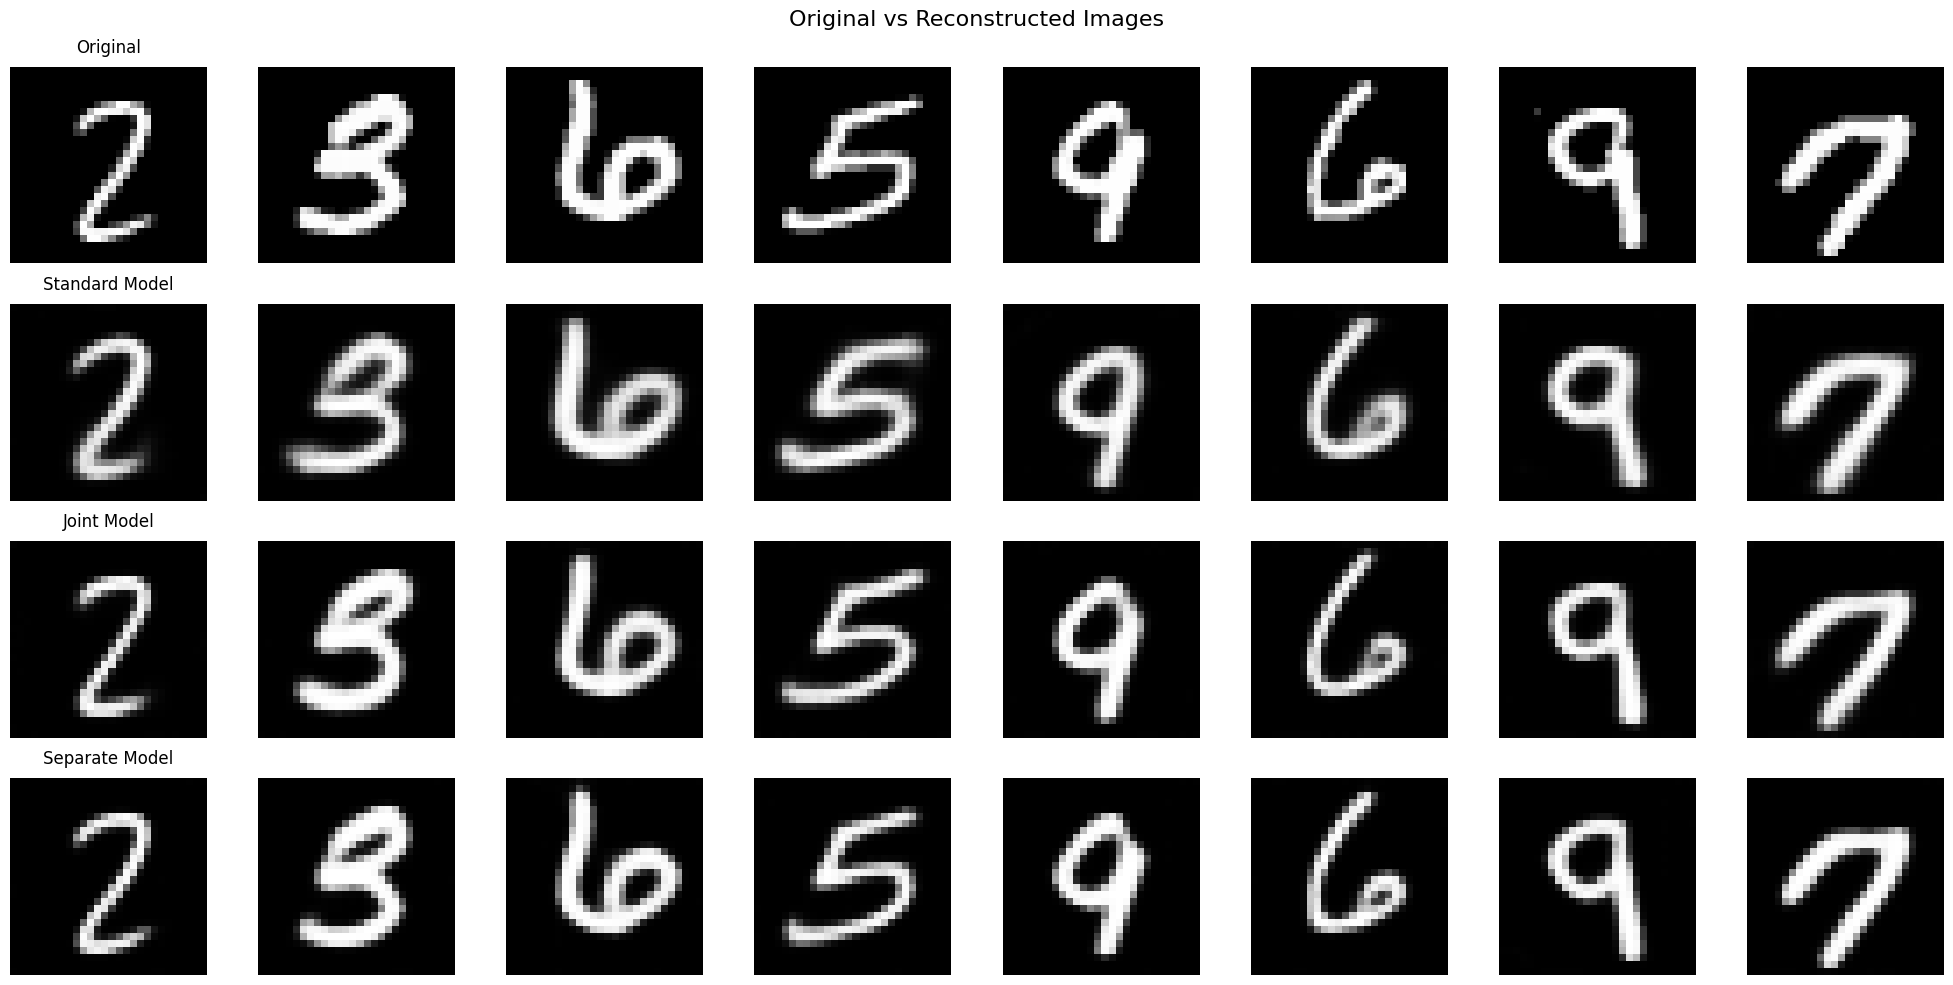

In [43]:
# Get test images
test_images, test_labels = next(iter(trainloader))
test_images = test_images.to(device)

# Get reconstructions from each model
reconstructions = []
with torch.no_grad():
    for classifier, decoder in models:
        z, _ = classifier(test_images)
        recon = decoder(z)
        reconstructions.append(recon.cpu().numpy())

# Convert test images to numpy for plotting
test_images = test_images.cpu().numpy()

# Plot original and reconstructed images
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
fig.suptitle('Original vs Reconstructed Images', fontsize=16)

# Plot original images
for i in range(8):
    axes[0,i].imshow(test_images[i,0], cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original', pad=10)

# Plot reconstructions for each model
model_names = ['Standard Model', 'Joint Model', 'Separate Model']
for row, (recon, name) in enumerate(zip(reconstructions, model_names), start=1):
    for i in range(8):
        axes[row,i].imshow(recon[i,0], cmap='gray')
        axes[row,i].axis('off')
        if i == 0:
            axes[row,i].set_title(name, pad=10)

plt.tight_layout()
plt.show()


## Supervised Variational Autoencoder

In [6]:
from SVAE import SVAE

svae = SVAE(latent_dim=latent_dim, num_classes=10, device=device)

Let's train

In [13]:
svae.train_model(trainloader, num_epochs=5, lr=0.001, beta=0.01, alpha=10.0)


Epoch [1/5]:
Total Loss: 68.4390
Reconstruction Loss: 66.2048
KL Loss: 201.7791
Classification Loss: 0.0216
Epoch [2/5]:
Total Loss: 64.4118
Reconstruction Loss: 61.9695
KL Loss: 220.5586
Classification Loss: 0.0237
Epoch [3/5]:
Total Loss: 62.5817
Reconstruction Loss: 60.1285
KL Loss: 220.4005
Classification Loss: 0.0249
Epoch [4/5]:
Total Loss: 61.3900
Reconstruction Loss: 58.9799
KL Loss: 217.7436
Classification Loss: 0.0233
Epoch [5/5]:
Total Loss: 60.4544
Reconstruction Loss: 58.0867
KL Loss: 214.2781
Classification Loss: 0.0225


In [17]:
# Save the trained SVAE model
torch.save(svae.state_dict(), 'models/svae_model.pth')


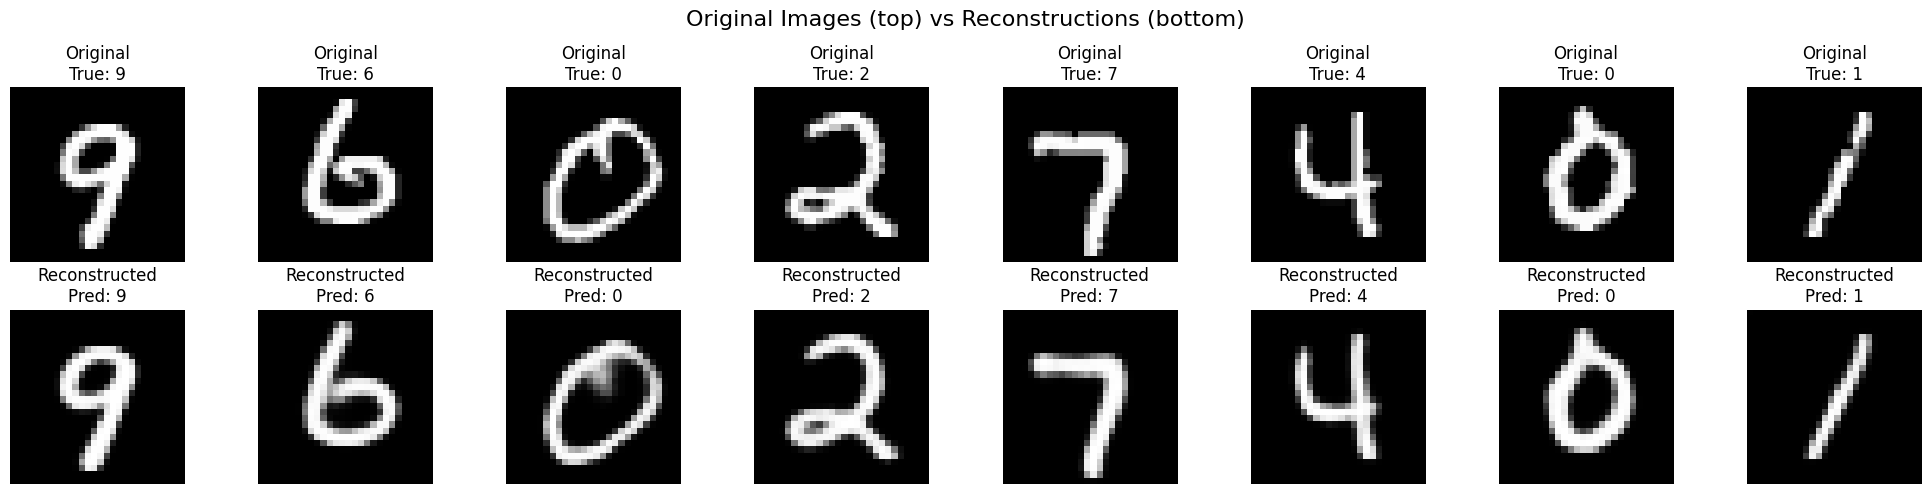

Classification Accuracy: 1.0000


In [15]:
# Test SVAE reconstruction and classification
test_images, test_labels = next(iter(trainloader))
test_images = test_images.to(device)
test_labels = test_labels.to(device)

# Get reconstructions and predictions
with torch.no_grad():
    # Change this line - the SVAE forward method returns (x_recon, y_pred, mu, log_var)
    x_recon, y_pred, mu, log_var = svae(test_images)
    # Apply softmax before argmax
    pred_probs = torch.softmax(y_pred, dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)

# Convert tensors to numpy for plotting
test_images = test_images.cpu().numpy()
recon_batch = x_recon.cpu().numpy()
test_labels = test_labels.cpu().numpy()
pred_labels = pred_labels.cpu().numpy()

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
fig.suptitle('Original Images (top) vs Reconstructions (bottom)', fontsize=16)

for i in range(8):
    # Original images
    axes[0, i].imshow(test_images[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f'Original\nTrue: {test_labels[i]}')
    axes[0, i].axis('off')
    
    # Reconstructed images
    axes[1, i].imshow(recon_batch[i].squeeze(), cmap='gray')
    axes[1, i].set_title(f'Reconstructed\nPred: {pred_labels[i]}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Calculate and print classification accuracy
accuracy = (pred_labels == test_labels).mean()
print(f'Classification Accuracy: {accuracy:.4f}')


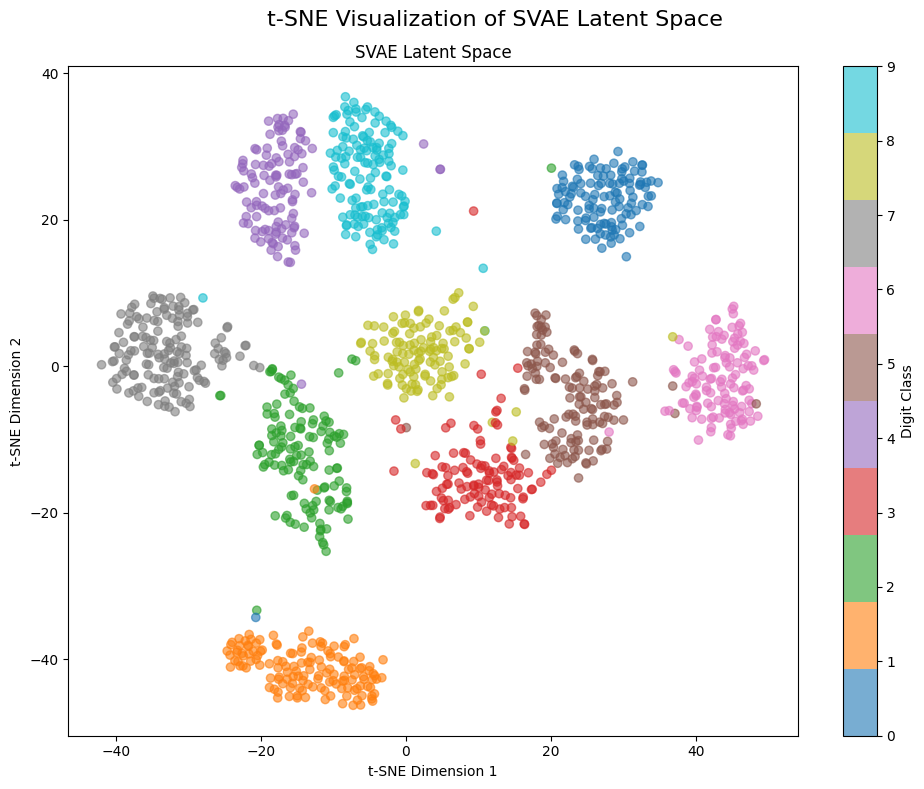

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Get more images from trainloader
all_images = []
all_labels = []
num_batches = 20  # Increased from 5 to 20 batches of data

for i, (images, labels) in enumerate(trainloader):
    if i >= num_batches:
        break
    all_images.append(images)
    all_labels.append(labels)

# Concatenate all batches
test_images_tensor = torch.cat(all_images, dim=0).to(device)
test_labels = torch.cat(all_labels, dim=0).cpu().numpy()

# Get latent representations for test data
with torch.no_grad():
    mu, log_var = svae.encode(test_images_tensor)
    z = svae.reparameterize(mu, log_var)
    latent_reps = z.cpu().numpy()

# Create the figure for t-SNE visualization
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle('t-SNE Visualization of SVAE Latent Space', fontsize=16)

# Run t-SNE and plot
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_reps)
scatter = ax.scatter(latent_2d[:, 0], latent_2d[:, 1], c=test_labels, cmap='tab10', alpha=0.6)
ax.set_title('SVAE Latent Space')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')

# Add colorbar
plt.colorbar(scatter, label='Digit Class')

plt.tight_layout()
plt.show()


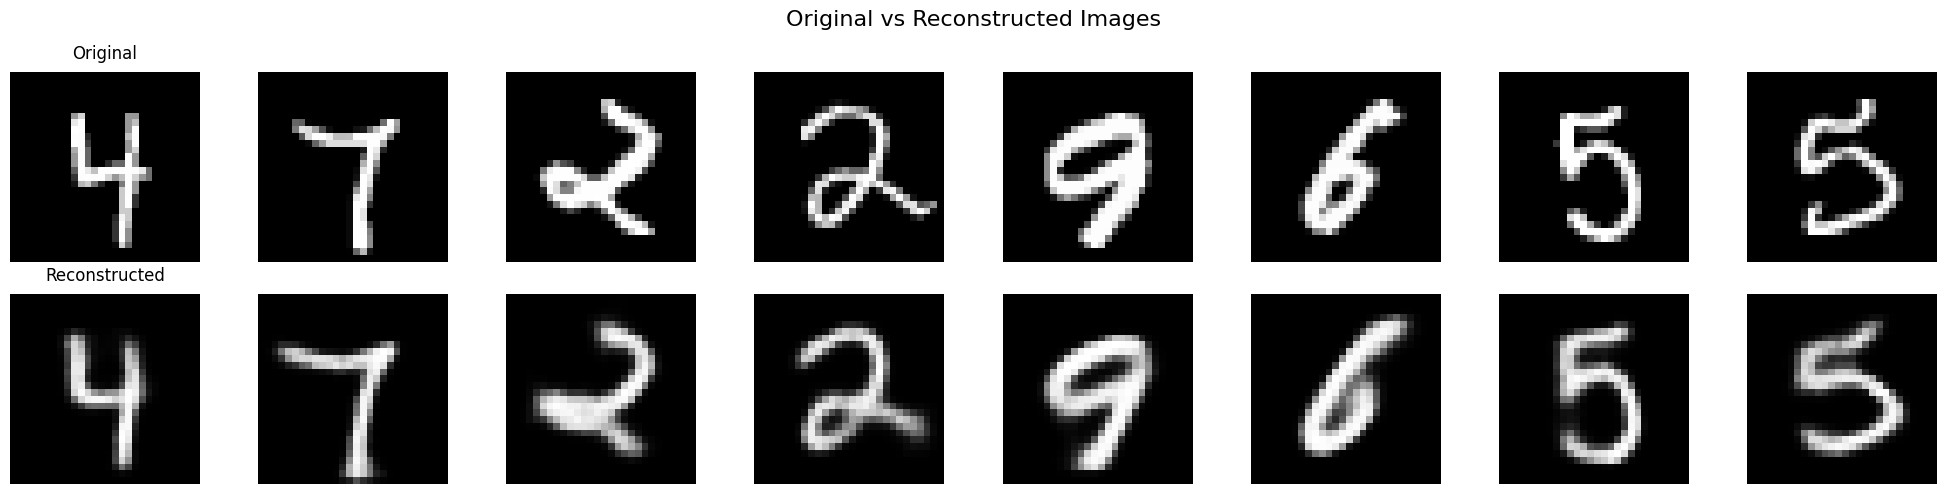

In [12]:
# Get a batch of test images
test_iter = iter(trainloader)
test_images, _ = next(test_iter)
test_images = test_images.to(device)

# Get reconstructions
with torch.no_grad():
    mu, log_var = svae.encode(test_images)
    z = svae.reparameterize(mu, log_var)
    reconstructions = svae.decode(z)

# Plot original vs reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
fig.suptitle('Original vs Reconstructed Images', fontsize=16)

for i in range(8):
    # Original images
    axes[0,i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original', pad=10)
    
    # Reconstructed images
    axes[1,i].imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
    axes[1,i].axis('off')
    if i == 0:
        axes[1,i].set_title('Reconstructed', pad=10)

plt.tight_layout()
plt.show()
